# **Evaluating the Performance of Water Quality Actions: UCD PA Project by E M**

# Import packages 


In [1]:
# Import Pandas and Numpy
import pandas as pd
import numpy as np
!pip install simpledbf
from simpledbf import Dbf5

# Import pyplot and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import from sklearn 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

# Import category_encoders - needed to install on Colab
!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read In Data and Pre-Process

Read in data on the Areas for Action from the Local Authority website

In [2]:
# Read in dbf file
AFA_dbf = Dbf5('WFD_AreasForAction_10072019.dbf')
# Convert to df
AFA = AFA_dbf.to_dataframe()
print("AFA.columns: ", AFA.columns)
# Remane the waterbody code column the standard name: EU_CD
AFA.rename(columns={'EU_WB_Code': 'EU_CD'}, inplace=True)
# Review the data:
print("Numbers of waterbodies in the dataset: ", len(AFA.index))
print("Numbers of unique Areas for Action in the dataset: ", len(AFA.Area_Name.unique()))

AFA.columns:  Index(['Area_Name', 'AFA_ID', 'EU_WB_Code', 'WB_Name', 'WB_Type', 'Start_Year',
       'Progress'],
      dtype='object')
Numbers of waterbodies in the dataset:  724
Numbers of unique Areas for Action in the dataset:  189


The Names of the Areas for Actions contain many special characters - remove these with Regex

In [3]:
AFA.Area_Name = AFA.Area_Name.str.strip()     
AFA.Area_Name = AFA.Area_Name.str.replace(' ', '_')         
AFA.Area_Name = AFA.Area_Name.str.replace(r"[^a-zA-Z\d\_]+", "")
print(AFA.Area_Name)

0                Adrigole
1                Adrigole
2                 Aherlow
3                 Aherlow
4                 Aherlow
              ...        
719       Wexford_Harbour
720       Wexford_Harbour
721              Woodford
722              Woodford
723    Yellow_Ballinamore
Name: Area_Name, Length: 724, dtype: object


<ipython-input-3-fc0e38d9d18d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  AFA.Area_Name = AFA.Area_Name.str.replace(r"[^a-zA-Z\d\_]+", "")


Lets collect more information on the all waterbodies from the EPA datasets

In [4]:
WaterData = pd.read_csv("WBInfo_EndCycle2_Dec2022.csv")
# Remane the waterbody code column the standard name: EU_CD
WaterData.rename(columns={'WaterbodyCode': 'EU_CD'}, inplace=True)
# Review the field names
print("WaterData.columns", WaterData.columns)
# remove spaces from field names
WaterData.columns = WaterData.columns.str.replace(' ', '')
#print(WaterData.describe)

# Set Catagorical data to put Status into Order
statusOrder = ['Bad', 'Poor', 'Moderate', 'Good', 'High']
WaterData['Status2013_2018'] = pd.Categorical(WaterData['Status2013_2018'], categories=statusOrder)
WaterData['Status2016_2021'] = pd.Categorical(WaterData['Status2016_2021'], categories=statusOrder)

WaterData.columns Index(['EU_CD', 'WaterbodyName', 'WaterbodyType', 'Region', 'LA',
       'CombinedCatchment', 'Cycle2AfA', 'Cycle3AfA', 'Cycle3Lead', 'DraftEO3',
       'Cycle3Risk', 'Status2010_2015', 'Status2013_2018', 'Status2016_2021',
       'Driver', 'ESTechnique', 'AchieveEO2010_2015', 'AchieveEO2013_2018',
       'AchieveEO2016_2021', 'StatusChange', 'ClassChange', 'StatusReversal',
       'EOChange', 'ClassChange18_21', 'Issues', 'PressureCount', 'Pressures',
       'Abstractions', 'Agriculture', 'Anthropogenic Pressures', 'Aquaculture',
       'Atmospheric', 'Domestic Waste Water', 'Forestry',
       'Historically Polluted Sites', 'Hydromorphology', 'Industry',
       'Invasive Species', 'Mines Quarries', 'Other Anthropogenic Pressures',
       'Peat.x', 'Urban Run-off', 'Urban Waste Water', 'Waste',
       'Water Treatment', 'P_Rank_1_3_v3R1', 'N_Rank_1_3_v3R1', 'DM1', 'DM2',
       'Catchment', 'Area_ha', 'P_Wastewater', 'P_Other_licenced_discharges',
       'P_Diffuse_Ur

Merge the Local Authority data with the EPA data

In [5]:
# Merge left on the AFA data so we only keep the waterbodies in the Areas for Action:
dfWaterAll = pd.merge(WaterData, AFA, on='EU_CD', how='left')
print(dfWaterAll.head())
print(len(dfWaterAll.index))

        EU_CD                WaterbodyName WaterbodyType   Region  \
0  GBNI4NB009                        Newry   Groundwater  Borders   
1  GBNI4NW003                       Claudy   Groundwater  Borders   
2  GBNI4NW008                      Ederney   Groundwater  Borders   
3  GBNI4NW020                  Belcoo Boho   Groundwater  Borders   
4  GBNI4NW022  Florence Court- Drumgormley   Groundwater  Borders   

             LA CombinedCatchment Cycle2AfA Cycle3AfA Cycle3Lead DraftEO3  \
0    Louth CoCo                 6       NaN       NaN        NaN     Good   
1  Donegal CoCo                 1       NaN       NaN        NaN     Good   
2  Donegal CoCo                36       NaN       NaN        NaN     Good   
3    Cavan CoCo                36       NaN       NaN        NaN     Good   
4    Cavan CoCo                36       NaN       NaN        NaN     Good   

   ... Well Total                      EOAssessment  \
0  ...  NaN   NaN                Decline - Reversed   
1  ...  NaN 

# Exploratory data analysis (EDA) and Data Preparation Part 1 (for all 4842 waterbodies)

Total number of Waterbodies  in Ireland :  4842
Percentage Net change in Waterbodies  in Ireland :  -2.0


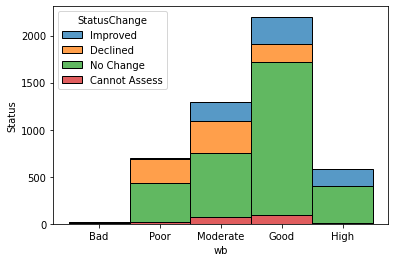

Total number of Waterbodies  outside of Areas for Action :  4121
Percentage Net change in Waterbodies  outside of Areas for Action :  -3.5


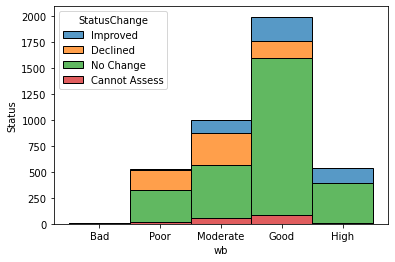

Total number of Waterbodies  in Areas for Action :  721
Percentage Net change in Waterbodies  in Areas for Action :  6.7


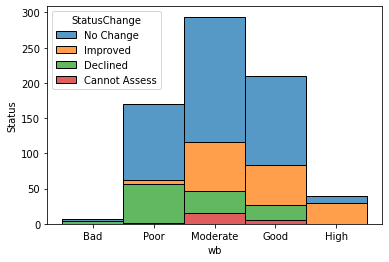

6.7

In [6]:
# # Calculate the net improvement rate for (1) all waterbodies, (2) within the AFAs and (3) outside of the AFAs:
# # Make a User defined function to do the calculation and plot the results
def PrintPercChange(df, fld, text, plot):  
    """ Calculate the number of improvements and declines, and print the % Net Change in Water quality, plot the Status """
    wb = len(df.index)
    improve = len(df.loc[df.StatusChange.str.contains('Improved')])
    decline = len(df.loc[df.StatusChange.str.contains('Declined')])
    net = improve - decline
    netPerc = round((net/wb)*100,1)
    if plot == True:
        print("Total number of Waterbodies ", text, ": ", wb)
        print("Percentage Net change in Waterbodies ", text, ": ", netPerc)
        # Plot histogram
        _ = sns.histplot(df, x=fld, hue="StatusChange", multiple="stack")
        _ = plt.xlabel('wb')
        _ = plt.ylabel('Status')
        plt.show()
    return netPerc

PrintPercChange(dfWaterAll, 'Status2016_2021', "in Ireland", True)
PrintPercChange(dfWaterAll.loc[dfWaterAll.Area_Name.isna()], 'Status2016_2021', "outside of Areas for Action", True)
PrintPercChange(dfWaterAll.loc[~dfWaterAll.Area_Name.isna()], 'Status2016_2021', "in Areas for Action", True)


The improvements in the Areas for Action may be influenced by the different distribution of the water quality in AFAs (Moderate dominate the data) compared to the national dataset (Good dominate the data) - the moderate status are more likely to improve than Good status waterbodies.

{'Bad': 10, 'Poor': 191, 'Moderate': 281, 'Good': 184, 'High': 34}
Check the numbers in the df Status Groups are greater than the numbers we want to sample:  Status2013_2018
Bad           24
Poor         466
Moderate     894
Good        1980
High         559
dtype: int64


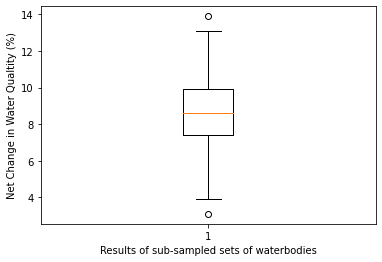

Mean % change in 500 sampled groups:  8.6


In [7]:
# # Count the number in each status class in the AFA waterbodies
statusAFA = dfWaterAll.loc[~dfWaterAll.Area_Name.isna(), ['EU_CD', 'Status2013_2018', 'StatusChange', 'Area_Name']]
# Create a dictionary for the numbers of waterbodies in each Status Group
gSize_dict = statusAFA.groupby('Status2013_2018', group_keys=False).size().to_dict()
print(gSize_dict)

# # Sample the waterbodies outside of the AFAs using the same distribution
statusNotAFA = dfWaterAll.loc[dfWaterAll.Area_Name.isna(), ['EU_CD', 'Status2013_2018', 'StatusChange', 'Area_Name']]

# Use Groupby on the areas outside of the AFAs
g = statusNotAFA.groupby('Status2013_2018', group_keys=False)
print("Check the numbers in the df Status Groups are greater than the numbers we want to sample: ", g.size())

netSmpld = pd.DataFrame()

for i in range(500): 
  # Sample without replacement using the AFA group sizes
  sampled_df = pd.DataFrame(g.apply(lambda x: x.sample(n=gSize_dict.get(x.name), random_state=i))).reset_index(drop=True)
  #print(sampled_df)
  # # Compare the rate of change between the AFAs and the re-sampled waterbodies outside of AFAs
  netSmpld.loc[i, 'NetPerc'] = PrintPercChange(sampled_df, 'Status2013_2018', "in sampled df", False)

# Plot the count of each pressure type 
_ = plt.boxplot(netSmpld)
_ = plt.xlabel('Results of sub-sampled sets of waterbodies')
_ = plt.ylabel('Net Change in Water Qualtity (%)')
plt.show()
print("Mean % change in 500 sampled groups: ", round(netSmpld.NetPerc.mean(),2))


The AFAs didn't perform better than a randomly selected set of waterbodies with the same Status distribution.




# Exploratory data analysis (EDA) and Data Preparation Part 2 (for the 721 waterbodies in the AFAs)

In [8]:
# # Filer only the AFA waterbodies
dfWater = dfWaterAll.loc[~dfWaterAll.Area_Name.isna(), :].copy()
print(dfWater.head())
print(len(dfWater.index))

              EU_CD WaterbodyName WaterbodyType             Region  \
41     IE_EA_07_273    Nadreegeal          Lake            Borders   
46  IE_EA_07A010050    ATHBOY_020         River  Midlands and East   
47  IE_EA_07A010070    ATHBOY_030         River  Midlands and East   
48  IE_EA_07A010100    ATHBOY_040         River  Midlands and East   
49  IE_EA_07A010300    ATHBOY_050         River  Midlands and East   

            LA CombinedCatchment   Cycle2AfA   Cycle3AfA Cycle3Lead DraftEO3  \
41  Cavan CoCo            26F, 7  Nadreegeel  Nadreegeel     LAWPRO     Good   
46  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
47  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
48  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
49  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   

    ...       Well      Total                          EOAssessment  \
41  ...        NaN        N

Now we can review the pressures that are causing water quality problems

18
Aquaculture                      0
Atmospheric                      0
WaterTreatment                   1
HistoricallyPollutedSites        1
OtherAnthropogenicPressures      4
Waste                            7
Abstractions                     7
MinesQuarries                   11
Peat.x                          22
InvasiveSpecies                 23
Industry                        25
AnthropogenicPressures          37
DomesticWasteWater              40
UrbanRun-off                    68
UrbanWasteWater                 71
Forestry                        88
Hydromorphology                167
Agriculture                    316
dtype: int64


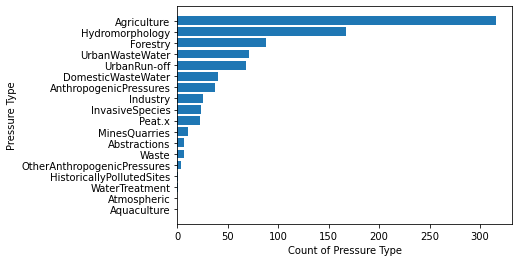

In [9]:
# Pull out the pressure Types from the col names
PressureTypes = dfWater.iloc[:, 27:45].columns.tolist()   # 'Abstractions':'WaterTreatment'
#print(PressureTypes)
print(len(PressureTypes))
PressureCount = dfWater[PressureTypes].count().sort_values()
print(PressureCount)

# Plot the count of each pressure type 
_ = plt.barh(PressureCount.index, width = PressureCount)
_ = plt.xlabel('Count of Pressure Type')
_ = plt.ylabel('Pressure Type')
plt.show()


This data needs some pre-processing and cleaning. 
Also, there are many different pressure types - group some of the less frequest ones into a new category = Other

In [10]:
# The Pressure Type Flags contain Values = True, NA. Fill NA with False and convert to int.
dfWater.loc[:, PressureTypes] = dfWater.loc[:, PressureTypes].fillna(False).astype(int)

#There are many pressure types - pre-process these data and group some of the infrequent pressure types into 'Other'
#Create a new Pressuretype group = Other
PressureOther = {'Abstractions', 'AnthropogenicPressures', 'Aquaculture', 'Atmospheric', 'DomesticWasteWater', 'MinesQuarries', 'Peat.x', 
                      'HistoricallyPollutedSites', 'Industry', 'InvasiveSpecies', 'OtherAnthropogenicPressures', 'Waste', 'WaterTreatment'}
dfWater.loc[:, 'Other'] = dfWater.loc[:, PressureOther].sum(axis=1)
# Update the Pressures List
PressuresList = list(set(PressureTypes) - set(PressureOther))
PressuresList += ['Other']
print(PressuresList)
print(dfWater.head())

['UrbanWasteWater', 'UrbanRun-off', 'Forestry', 'Agriculture', 'Hydromorphology', 'Other']
              EU_CD WaterbodyName WaterbodyType             Region  \
41     IE_EA_07_273    Nadreegeal          Lake            Borders   
46  IE_EA_07A010050    ATHBOY_020         River  Midlands and East   
47  IE_EA_07A010070    ATHBOY_030         River  Midlands and East   
48  IE_EA_07A010100    ATHBOY_040         River  Midlands and East   
49  IE_EA_07A010300    ATHBOY_050         River  Midlands and East   

            LA CombinedCatchment   Cycle2AfA   Cycle3AfA Cycle3Lead DraftEO3  \
41  Cavan CoCo            26F, 7  Nadreegeel  Nadreegeel     LAWPRO     Good   
46  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
47  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
48  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   
49  Meath CoCo                 7      Athboy      Athboy     LAWPRO     Good   

    ...

Now review and manage missing data in the combined dataset

In [11]:
print(dfWater.dtypes)
print(dfWater.isnull().sum())
# Names of non-numeric cols
FeatureText = dfWater.select_dtypes(include='object').columns
print("Non-numerical colums in the data: ", FeatureText)
# Names of numeric cols
FeatureNum = dfWater.select_dtypes(include='number').columns
print("Numerical columns in the data", FeatureNum)
# Fill NA for numeric and text cols
dfWater.loc[:, FeatureNum] = dfWater.loc[:, FeatureNum].replace(np.nan, 0, regex=True)
dfWater.loc[:, FeatureText] = dfWater.loc[:, FeatureText].replace(np.nan, '', regex=True)
print(dfWater.head())
# # Save out csv for review
dfWater.to_csv("dfWater_Check.csv", header=True)

EU_CD             object
WaterbodyName     object
WaterbodyType     object
Region            object
LA                object
                  ...   
WB_Name           object
WB_Type           object
Start_Year       float64
Progress          object
Other              int64
Length: 80, dtype: object
EU_CD            0
WaterbodyName    0
WaterbodyType    0
Region           0
LA               0
                ..
WB_Name          0
WB_Type          0
Start_Year       0
Progress         0
Other            0
Length: 80, dtype: int64
Non-numerical colums in the data:  Index(['EU_CD', 'WaterbodyName', 'WaterbodyType', 'Region', 'LA',
       'CombinedCatchment', 'Cycle2AfA', 'Cycle3AfA', 'Cycle3Lead', 'DraftEO3',
       'Cycle3Risk', 'Status2010_2015', 'Driver', 'ESTechnique',
       'AchieveEO2010_2015', 'AchieveEO2013_2018', 'AchieveEO2016_2021',
       'StatusChange', 'ClassChange', 'StatusReversal', 'EOChange', 'Issues',
       'Pressures', 'Catchment', 'EOAssessment', 'ResponseCategory',

# Exploratory data analysis (EDA) and Data Preparation Part 3 (for the 189 Areas for Action)

Lets summarise all of this data for each of the 189 Areas for Action to create a performance score for each of the Areas - then we can try predict this score from the features to understand why some performed better that others.

                          countWB  NetChange   AFA_Score
AFA_Name                                                
Nadreegeel                    2.0        0.0    0.000000
Athboy                        6.0        1.0   16.666667
Moynalty                      8.0        3.0   37.500000
Blackwater_Longwood           4.0       -1.0  -25.000000
Boycetown                     2.0        0.0    0.000000
...                           ...        ...         ...
Unshin                        4.0       -1.0  -25.000000
Glencar_Lake                  1.0        1.0  100.000000
OwenmoreTemplehouse_Lake      7.0        1.0   14.285714
Upper_Bonet                   3.0        0.0    0.000000
Lough_Gill                    2.0       -1.0  -50.000000

[189 rows x 3 columns]
Mean number of WB in the Areas for Action:  4.2


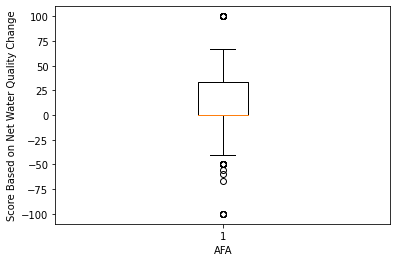

In [12]:
# Make new df for the AFA summary information
AFANames = dfWater.Area_Name.unique()
# Clear df_AFA
df_AFA = None  
df_AFA = pd.DataFrame()
df_AFA['AFA_Name'] = AFANames
# Set the index to the AFA name
df_AFA = df_AFA.set_index('AFA_Name')

# # Now for each Area, we calculate a performance score based on the chage in water quality: Improved, Declined, or No Change
# The column that looks at the change is text!! We can take improved = 1, nochange = 0, declined = -1:
for i in AFANames:
    # NetChange = dfWater.loc[(dfWater['Area_Name'].str.contains(i)), 'ClassChange18_21'].sum()
    # df_AFA.loc[i,'NetChange'] = NetChange
    # #print(i, NetChange)
    countWB = len(dfWater.loc[(dfWater['Area_Name'].str.contains(i))])
    df_AFA.loc[i,'countWB'] = countWB
    # df_AFA.loc[i,'AFA_Score'] = (NetChange / countWB)
    sumImprove = len(dfWater.loc[(dfWater['Area_Name'].str.contains(i)) & (dfWater.StatusChange.str.contains('Improved'))])
    #df_AFA.loc[i, 'sumImprove'] = sumImprove
    sumDeclined = len(dfWater.loc[(dfWater['Area_Name'].str.contains(i)) & (dfWater.StatusChange.str.contains('Declined'))])
    #df_AFA.loc[i,'sumDeclined'] = sumDeclined
    sumNoChange = len(dfWater.loc[(dfWater['Area_Name'].str.contains(i)) & (dfWater.StatusChange.str.contains('No Change'))])
    # We will take the Cannot Assess to == No Change
    sumNoChange += len(dfWater.loc[(dfWater['Area_Name'].str.contains(i)) & (dfWater.StatusChange.str.contains('Cannot Assess'))])
    #df_AFA.loc[i,'sumNoChange'] = sumNoChange
    NetChange = sumImprove - sumDeclined
    df_AFA.loc[i,'NetChange'] = NetChange
    #print(i, sumImprove, sumDeclined, sumNoChange, NetChange)
    df_AFA.loc[i,'AFA_Score'] = (NetChange / (sumImprove + sumDeclined + sumNoChange))*100

print(df_AFA)
print('Mean number of WB in the Areas for Action: ', np.round(df_AFA.countWB.mean(),2))
#print('Mean % Change in water quality of the Areas for Action: ', np.round(df_AFA.AFA_Score.mean(),2))

# Plot the new performance score of each Area for Action 
_ = plt.boxplot(df_AFA.AFA_Score)
_ = plt.xlabel('AFA')
_ = plt.ylabel('Score Based on Net Water Quality Change')
plt.show()

There are 4.22 waterbodies per Area for Action, on average. The Mean Net Change in Water Quality was +6.8%, and the range is from -100% to +100%. Now summarise the Features data for each Area for Action:

In [13]:
# dfWater has data on each of the 724 waterbodies in the 189 AFA - summarise these to create useful feature variables

# Results from source apporionment analysis
SLAM_Cols = FeatureNum[25:36]
print(SLAM_Cols)
Soil_Cols = FeatureNum[36:45]
print(Soil_Cols)

# Implement a function PrsrToAFA
def PrsrToAFA(df_in, colName, df_out):  
    """ For each AFA, count the pressures in each pressure type and get the earliest start date for actions in the area """
    # filter dfWater for AFA
    df = df_in.loc[df_in[colName].str.contains(i)]
    # Sum the pressures count field  
    df_out.loc[i,'PressureCount'] = df['PressureCount'].mean()
    # Sum the pressures assigned
    for j in PressuresList:
      df_out.loc[i, j] = df[j].sum()
    # # # SLAM cols
    #for k in SLAM_Cols:
    #  df_out.loc[i, k] = df[k].mean()
    # Summary variable from SLAM cols
    df_out.loc[i,'P_Waste_Arab'] = (df['P_Wastewater'] + df['P_Arable']).mean()
    # Include a new field - Normalise per area: P_Total_kgYr  
    df_out.loc[i,'P_Total_kgHaYr'] = (df['P_Total_kgYr']/df['Area_ha']).mean()
    # Soil_Cols km2 area per waterbody
    # for k in Soil_Cols:
    #   df_out.loc[i, k] = df[k].sum()
    # Summary variable from Soil cols
    df_out.loc[i,'Soils_Wet'] = (df['Peat.y'] + df['Poor']+ df['VeryPoor']).sum()
    # Sum the actions indicator field  
    df_out.loc[i,'DM1'] = df['DM1'].mean()
    # Sum the actions indicator field  
    df_out.loc[i,'DM2'] = df['DM2'].mean()
    # Average PIP stats: P_Rank_1_3_v3R1
    df_out.loc[i,'P_Rank_1_3_v3R1'] = df['P_Rank_1_3_v3R1'].mean()
    # Average PIP stats: N_Rank_1_3_v3R1
    df_out.loc[i,'N_Rank_1_3_v3R1'] = df['N_Rank_1_3_v3R1'].mean()
    # Region 
    df_out.loc[i,'Region'] = df['Region'].min()
    # Catchment 
    df_out.loc[i,'Catchment'] = df['Catchment'].min()
    
# # Call the function for summarise the AFA data
for i in AFANames:
    PrsrToAFA(dfWater, 'Area_Name', df_AFA)

# # Fill na in the new field 
df_AFA.P_Total_kgHaYr = df_AFA.P_Total_kgHaYr.fillna(0)


Index(['P_Wastewater', 'P_Other_licenced_discharges', 'P_Diffuse_Urban',
       'P_Septi_Tanks', 'P_Pasture', 'P_Arable', 'P_Forestry', 'P_Peat',
       'P_Deposition', 'P_Total_kgYr', 'P_Urban_2018'],
      dtype='object')
Index(['Alluvium', 'Imperfect', 'Made', 'Peat.y', 'Poor', 'VeryPoor', 'Water',
       'Well', 'Total'],
      dtype='object')


Calculate and visualise the correlations between the target variable and the features


Corr:             AFA_Score  Soils_Wet
AFA_Score    1.00000    0.04327
Soils_Wet    0.04327    1.00000


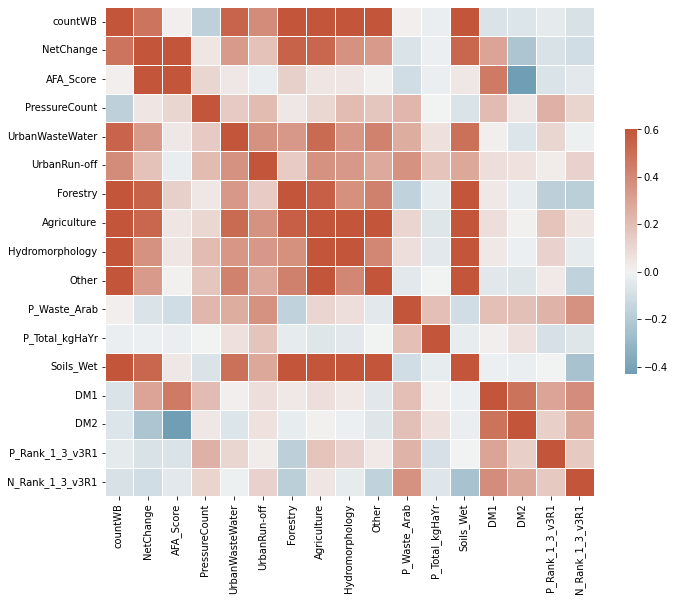

In [14]:
# Check correlations
#print(df_AFA.corr())

# Set up a matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap 
sns.heatmap(df_AFA.corr(), cmap=cmap, vmax=.6, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Spot check a correaltion
print("Corr: ", df_AFA[['AFA_Score','Soils_Wet']].corr())

# Print out the df for review
df_AFA.to_csv("df_AFA_Check.csv", header=True)

Visualise some of the data in the new dataset in a pairplot (Note: this is slow to run)

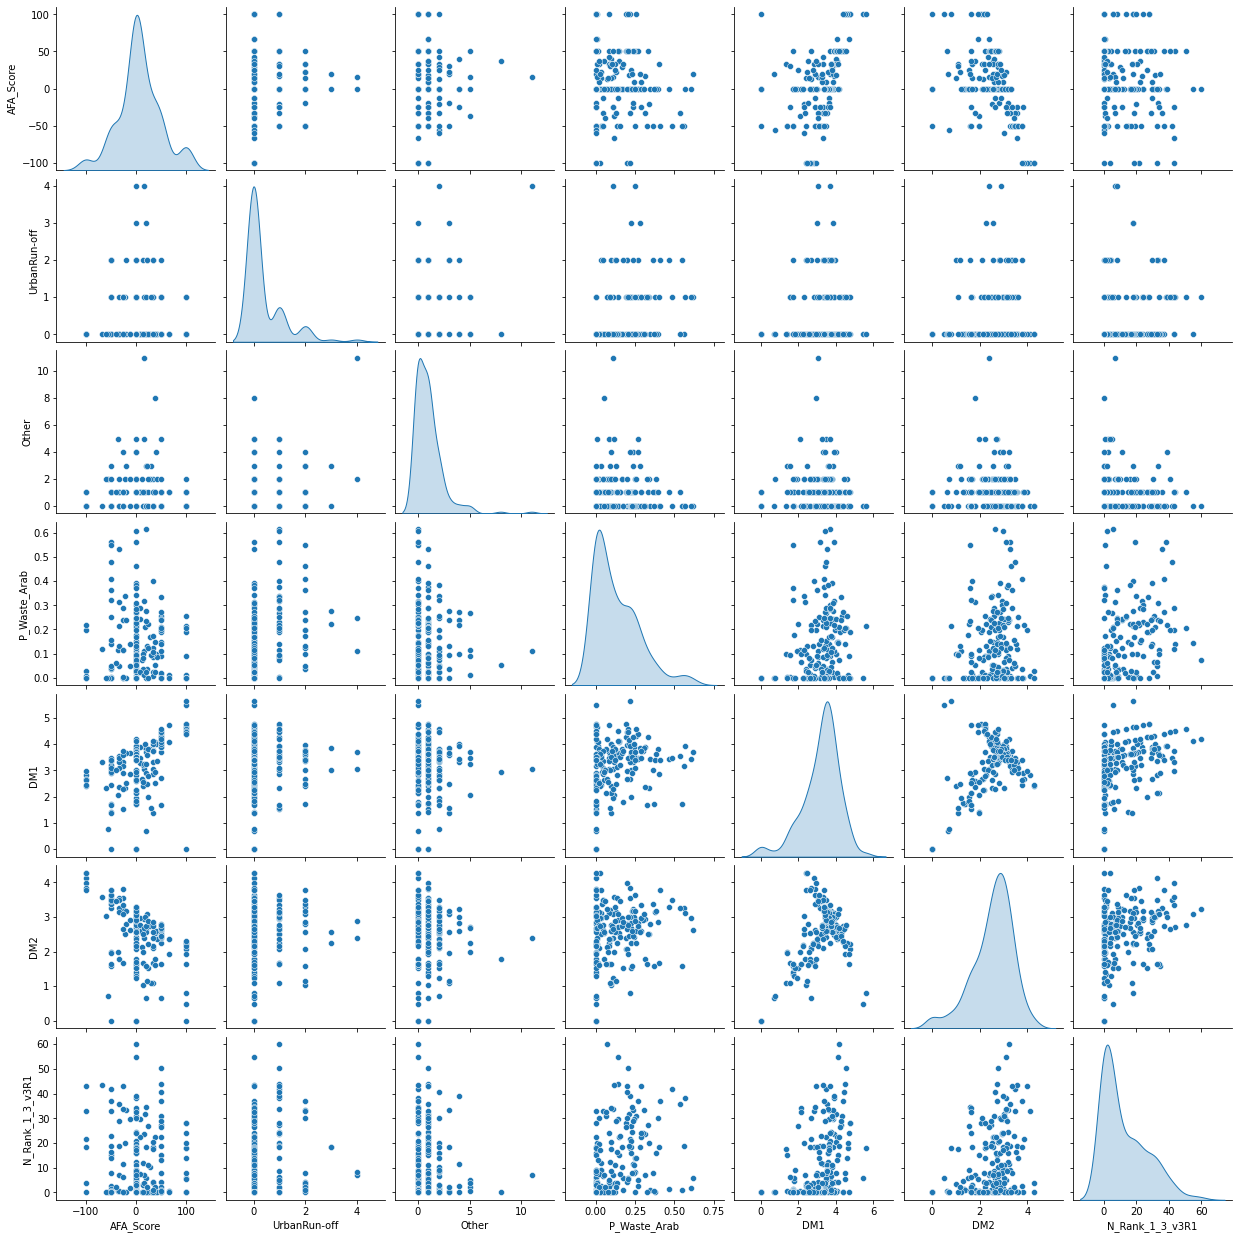

In [15]:
sns.pairplot(df_AFA.iloc[:, [2,5,9,10,13,14,16]], diag_kind='kde')   # pairplot with density curve 


# Train and Evaluate the Model

Preprocess the variables using Label encoder on the non-numerical cols and normalise the data with StandardScalar (this is important for LassoCV which is used below)

In [16]:
# # Create a label encoder object
le = preprocessing.LabelEncoder()

# Encode the text columns using fit_transform method
df_AFA['Region'] = le.fit_transform(df_AFA['Region'])
df_AFA['Catchment'] = le.fit_transform(df_AFA['Catchment'])

# set X and y
X = df_AFA.drop(['NetChange', 'AFA_Score'], axis=1)
#X = df_AFA.loc[:, ['P_Waste_Arab', 'DM1', 'DM2', 'Catchment']]

var_names = df_AFA.drop(['NetChange', 'AFA_Score'], axis=1).columns #  ['Agriculture', 'DM1', 'Region', 'Catchment']  
#var_names =  ['P_Waste_Arab', 'DM1', 'DM2', 'Catchment']  
y = df_AFA['AFA_Score']  

# Split the dataframe into training and testing sets with 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=321)

from sklearn.preprocessing import StandardScaler
# Scale input variables using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LinearRegression 
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# If the training and test scores are comparable then the model isn't overfitted:
print('Training set accuracy score: {:.4f}'.format(lr.score(X_train_scaled, y_train)))
print('Test set score : {:.4f}'.format(lr.score(X_test_scaled, y_test)))
 

Training set accuracy score: 0.8493
Test set score : 0.7898


# Hyper Parameter Tuning

Best alpha: 1.010000
Coefficients: [-4.34771553e-01  0.00000000e+00 -0.00000000e+00 -1.28284913e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.65082911e-02
 -1.31453464e+00  0.00000000e+00 -0.00000000e+00  3.74495896e+01
 -3.31353001e+01 -8.21871765e+00 -3.04117061e+00 -1.94352251e+00
  0.00000000e+00]


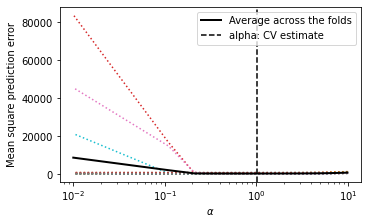

In [17]:
from numpy import arange
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV

#define alpha range
alphas = arange(0.01, 10, 0.1) #create an array of alpha values from 0.01 to 1 with a step of 0.01

#define cross-validation scheme
cv = RepeatedKFold(n_splits=6, n_repeats=3) #create a cross-validation object that splits the data into 5 folds and repeats it 3 times

#fit lasso model with cross-validation and return path 
model = LassoCV(alphas=alphas, cv=cv) #create a lasso model object that uses the alpha range and cross-validation scheme defined above and returns path 
model.fit(X_train_scaled, y_train) #fit the model to the data

#print best alpha and coefficients
print('Best alpha: %f' % model.alpha_) #print the best alpha value found by cross-validation
print('Coefficients: %s' % model.coef_) #print the coefficients for each feature corresponding to the best alpha value

# # Plot the MSE and alphas
_ = plt.figure(figsize=(5, 3), constrained_layout=True)
_ = plt.semilogx(model.alphas_, model.mse_path_, ':')
_ = plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
_ = plt.axvline(model.alpha_, linestyle='--', color='k', label='alpha: CV estimate')
_ = plt.legend()
_ = plt.xlabel(r'$\alpha$')
_ = plt.ylabel('Mean square prediction error')
plt.show()


Review the Best Model and the important variables identified by Lasso


Lasso picked 9 variables and eliminated the other 8 variables


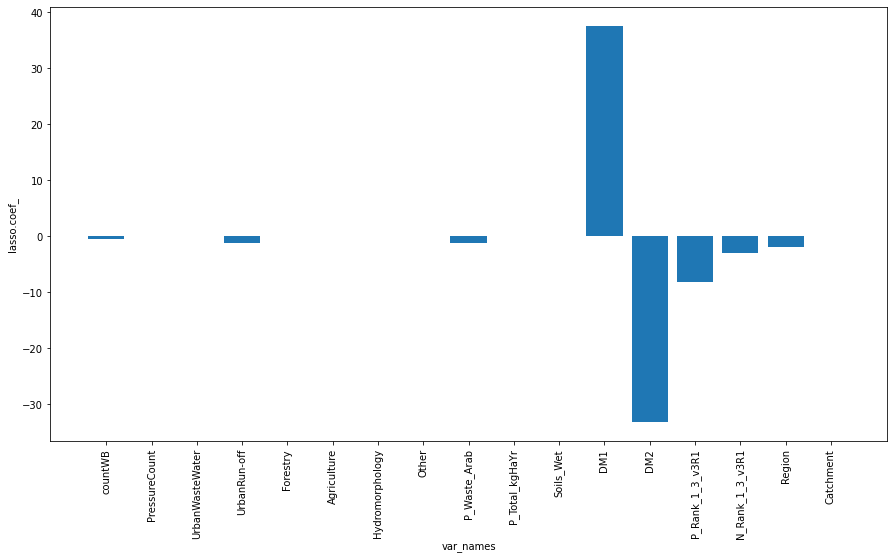

R squared training set 0.84
R squared test set 0.82


In [18]:
# Fit a lasso regression model on the scaled training data using the best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_scaled, y_train)

# Review the selected parameters
coef = pd.Series(lasso_best.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

# plot the lasso coefficients
_ = plt.figure(figsize=(15,8))
_ = plt.bar(var_names, lasso_best.coef_)
_ = plt.xticks(rotation=90)
_ = plt.ylabel('lasso.coef_')
_ = plt.xlabel('var_names')
plt.show()

# If the training and test scores are comparable then the model isn't overfitted:
print('R squared training set', round(lasso_best.score(X_train_scaled, y_train), 2))
print('R squared test set', round(lasso_best.score(X_test_scaled, y_test), 2))


Hyper-parameter tuning improved the model performance.